In [14]:
%load_ext autoreload
%autoreload 2
import sys
dirr = "../../src"
if dirr not in sys.path:
    sys.path.append(dirr)
%xmode Plain
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import utils as helper

tennis = "../../data/tennis/tennis.csv"
iris = "../../data/iris/iris.csv"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Exception reporting mode: Plain


In [2]:
from rf import RandomForestClassifier
from sklearn.model_selection import train_test_split
from dt import DecisionTreeClassifier
from IPython.display import clear_output
from sklearn.utils import shuffle
from adb import AdaBoost
import time

In [3]:
data = pd.read_csv(tennis)
data.head(3)

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes


---
## Question 1
**a) and b)** Using Parallelism internally by the use of ``Pool`` in ``multiprocessing`` library. Look at ``rf.py`` for the exact details.

In [4]:
rf = RandomForestClassifier(max_depth=2, num_of_trees=3, jobs=2)
rf.train(data)

In [5]:
data.head(7)

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes


In [6]:
rf.predict(data.iloc[:7, :-1])

,0
0,yes
1,yes
2,yes
3,yes
4,yes
5,yes
6,yes


In [7]:
# this is the individual prediction of the dts
rf.preds

,0,0,0
0,yes,yes,yes
1,yes,yes,yes
2,yes,yes,yes
3,yes,yes,yes
4,yes,yes,yes
5,yes,yes,yes
6,yes,yes,yes


In [8]:
for dt_roots in rf.roots:
    print (helper.parser(dt_roots))

Question: Is 2th Column = overcast
  T: Predict: yes
  F: Question: Is 0th Column = hot
    T: Predict: no
    F: Predict: yes

Question: Is 2th Column = overcast
  T: Predict: yes
  F: Question: Is 0th Column = hot
    T: Predict: no
    F: Predict: yes

Question: Is 2th Column = overcast
  T: Predict: yes
  F: Question: Is 0th Column = hot
    T: Predict: no
    F: Predict: yes



---
## Question 1
**c)** Below are the plot representing the change in performance with increase in jobs.

In [9]:
import time
def timer(data, jobs, num):
    rf = RandomForestClassifier(method = 'gini',
                                max_depth=2,
                                jobs=jobs,
                                num_of_trees=num)
    dTrain, dTest = train_test_split(data, test_size=.3)
    start = time.time()
    rf.train(dTrain)
    end = time.time()
    train = end-start
    start = time.time()
    rf.predict(dTest.iloc[:, :-1])
    end = time.time()
    test = end-start
    return train, test

In [10]:
# timing with # of jobs
tr, ts = [], []
for job in range(1, 5):
    train, test = timer(data, job, num=5) # training 5 trees
    tr.append(train)
    ts.append(test)

In training we see there is marginal (my cpu isn't powerfull) increase in preformance

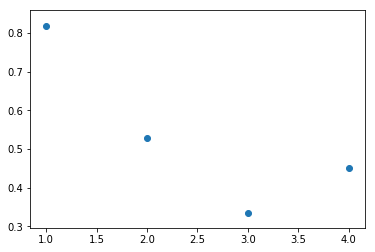

In [11]:
# plot training time w.r.t. # of jobs
plt.scatter(range(1, 5), tr)

In Prediction we see that there doesn't seem to be any improvement in performance

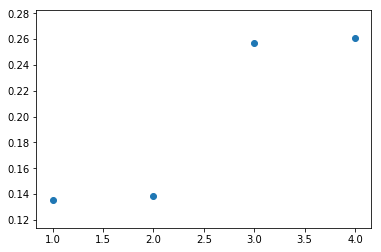

In [12]:
# plot predicition time w.r.t. # of jobs
plt.scatter(range(1, 5), ts)

---
## Question 1
**d)** Using RF on IRIS data set.

In [13]:
data = pd.read_csv(iris, header=None)
data.head(3)

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


In [14]:
#splitting data
dTrain, dTest = train_test_split(data, test_size=.3)
rf = RandomForestClassifier(method='gini',
                            max_depth=2,
                            num_of_trees=20,
                            frac=None, # selects root(p) by dflt
                            jobs=4)
dt = DecisionTreeClassifier(method='gini',
                            max_depth=2)

In [15]:
# training
rf.train(dTrain)
dt.train(dTrain)

In [16]:
# predicting
rf_preds = rf.predict(dTest.iloc[:, :-1])
dt_preds = dt.predict(dTest.iloc[:, :-1])
true_labels = dTest.iloc[:, -1]

In [17]:
# finding the accuracies
dt_preds = np.squeeze(dt_preds.values)
rf_preds = np.squeeze(rf_preds.values)
true_labels = np.squeeze(true_labels.values)
total = true_labels.shape[0]
rf_acc = ((true_labels == rf_preds).sum())/total
dt_acc = ((true_labels == dt_preds).sum())/total
print('rf_acc:', rf_acc)
print('dt_acc:', dt_acc)

rf_acc: 0.35555555555555557
dt_acc: 0.9111111111111111


---
## Question 1
**e)** Using 5 fold cross-validation on IRIS dataset.

In [18]:
data = pd.read_csv("../../data/iris/iris.csv", header=None)
data.head(3)

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


In [19]:
def nested_cross(dTrain, depths, num_valid):
    folds = make_folds(dTrain, num_valid)
    # holding out test
    passed_folds = folds[:-1]
    k = best_k(passed_folds, depths)
    acc = 0
    for i in range(num_valid):
        curr_fold_train = [x for j,x in enumerate(folds) if j!=i] 
        curr_fold_test = folds[i]
        curr_fold_train = pd.concat(curr_fold_train)
        mydt = RandomForestClassifier(method='gini',
                                          max_depth=2,
                                          num_of_trees=k)
        mydt.train(curr_fold_train)
        my_preds = np.squeeze(mydt.predict(curr_fold_test.iloc[:, :-1]).values)
        true = curr_fold_test.iloc[:, -1].values
        my_acc = ((true == my_preds).sum())/curr_fold_test.shape[0]
        acc += my_acc/num_valid
    return {"depth": k, "acc": acc}   

def make_folds(dTrain, num_valid):
    '''Make a number of folds with diven pd'''
    train = shuffle(dTrain)
    last = train.shape[0]
    folds = []
    for i in range(num_valid):
        start = i*int(last/num_valid)
        end = (i+1)*int(last/num_valid)
        if end >= last:
            end = -1
        folds.append(train.iloc[start:end, :])
    return folds

def best_k(folds, depths):
    '''return depth that maximizes the avg accuracy'''
    num_valid = len(folds)
    acc = {}
    for i in range(num_valid):
        curr_fold_train = [x for j,x in enumerate(folds) if j!=i] 
        curr_fold_validation = folds[i]
        curr_fold_train = pd.concat(curr_fold_train)
        for k in depths:
            mydt = RandomForestClassifier(method='gini',
                                          max_depth=2,
                                          num_of_trees=k)
            mydt.train(curr_fold_train)
            my_preds = mydt.predict(curr_fold_validation.iloc[:, :-1])
            true = curr_fold_validation.iloc[:, -1]
            true = true.values
            my_preds = np.squeeze(my_preds.values)
            assert (true.shape == my_preds.shape)
            my_acc = ((true == my_preds).sum())/curr_fold_validation.shape[0]
            if k in acc.keys():
                acc[k] += my_acc
            else:
                acc[k] = my_acc
    acc = {k: acc[k]/num_valid for k in acc.keys()}
    
    x = acc
    print (acc) # for showcasing
    sorted_by_value = sorted(x.items(), key=lambda kv: kv[1])
    return sorted(x[0] for x in sorted_by_value if sorted_by_value[-1][1] == x[1])[0]


In [20]:
dic = nested_cross(data, [1, 2, 5, 10, 50, 100], 5)

{1: 0.35000000000000003, 2: 0.35000000000000003, 5: 0.35000000000000003, 10: 0.35000000000000003, 50: 0.41666666666666663, 100: 0.41666666666666663}


We observe bad performance in this case as we are randomly selecting only 2 of the 4 features available and those maybe bad features for the classification task

In [21]:
print ("optimal num_of_trees:", dic["depth"], "| with accuracy:", dic["acc"])

optimal num_of_trees: 50 | with accuracy: 0.3687356321839081


---
## Question 2
Submission for buldozer competetion.

---
## Question 3
a) Adaboost.

In [22]:
data = pd.read_csv(iris, header=None)
data.head(3)

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


In [23]:
# Re-encoding classes to be 'virginica', 'not-virginica'.
data.loc[data.loc[:, 4] != 'Iris-virginica', 4] = 'not-virginica'
data.loc[data.loc[:, 4] == 'Iris-virginica', 4] = 'virginica'
data.head(3)

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,not-virginica
1,4.9,3.0,1.4,0.2,not-virginica
2,4.7,3.2,1.3,0.2,not-virginica


In [24]:
data.tail(3)

,0,1,2,3,4
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


In [25]:
# dropping sepal width, petal length
data_dropped = data.drop(columns=[1,2])
data_dropped.head(2)

,0,3,4
0,5.1,0.2,not-virginica
1,4.9,0.2,not-virginica


In [28]:
X = data_dropped.values[:, :-1]
X[:3, :]

array([[5.1, 0.2],
       [4.9, 0.2],
       [4.7, 0.2]], dtype=object)

Converting the labels to 1, -1 ▼

In [29]:
y = data_dropped.values[:, -1]
msk = y == 'virginica'
y = (1 * msk) + (-1 * (np.logical_not(msk)))
y[:3]

array([-1, -1, -1])

In [30]:
a = AdaBoost(num_of_trees=10, max_depth=1)
clfs, alphas = a.train(X, y)

In [31]:
shows = a.weights[:3]
print ("Sample weights ▼")
for sh in shows:
    print (sh[:6])

Sample weights ▼
[0.006666666666666667, 0.006666666666666667, 0.006666666666666667, 0.006666666666666667, 0.006666666666666667, 0.006666666666666667]
[0.00347222 0.00347222 0.00347222 0.00347222 0.00347222 0.00347222]
[0.00198091 0.00198091 0.00198091 0.00198091 0.00198091 0.00198091]


In [32]:
def plot(accs, weights, X, y):
    num_of_trees = len(accs)
    for i in range(num_of_trees):
        mul = 10000
        pts = plt.scatter(X[:, 0], X[:, 1], s=weights[i]*mul, c=(y==y[0])*1.)
        plt.xlabel("sepal length")
        plt.ylabel("petal width")
        plt.title("Accuracy: " + str(accs[i]))
        plt.show()
        time.sleep(1)
        if (i != num_of_trees-1):
            clear_output()

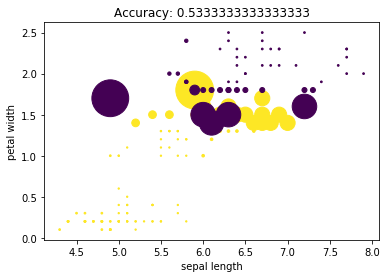

In [33]:
plot(a.accs, a.weights, X, y)

---
## Question 3
a) Adding noise.

Random noise

In [34]:
mask1 = X[:, 1] > 2.4
mask0 = X[:, 0] > 6.9
msk = mask1 & mask0
print (msk.sum())
nmsk = np.logical_not(msk)
y_chn = y*nmsk + msk*-y

1


In [35]:
mask1 = X[:, 1] < 0.2
mask0 = X[:, 0] < 4.4
msk = mask1 & mask0
print (msk.sum())
nmsk = np.logical_not(msk)
y_changed = y_chn*nmsk + msk*-y_chn

1


Training Adaboost Trees now. see the top right yellow blob and the bottom left purple noise added.

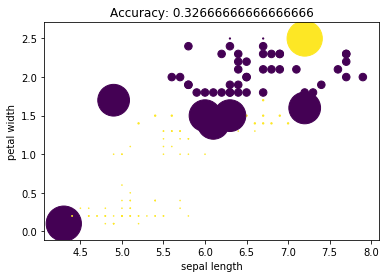

In [36]:
a_adv = AdaBoost(num_of_trees=10, max_depth=1)
clfs, alphas = a_adv.train(X, y_changed)
plot(a_adv.accs, a_adv.weights, X, y_changed)

We see that the Adaboost is trying to increase the weightage of the noisy missclassfied labels. We infer that Adaboost is really sensitive to outliers. If a human was to learn the labelling of the dataset, it would be apparent that these labels are noisy data and therefore intead ignore these misguiding examples.

---
## Question 4
Generating a dataset with random noise as Gaussian Distribution.

In [3]:
def dataset_generator(m, c, samples = 50, sigma=10): 
    """assumes random noise comes from
    Gaussian Distribution
    """
    X = np.arange(samples)
    random_noise = np.random.normal(scale=sigma, size=samples)
    Y = m*X + c + random_noise
    return X, Y

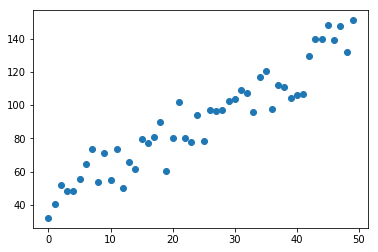

In [4]:
X, Y = dataset_generator(m=2, c=43, samples=50, sigma=10)
plt.scatter(X, Y)

**b)** Fitting a 5 degree polynomial to the data provided.

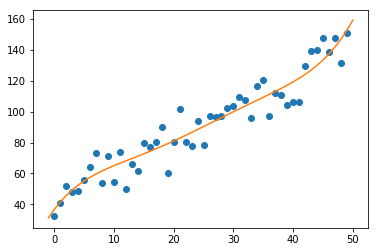

In [48]:
p = np.poly1d(np.polyfit(X, Y, deg=5))

t = np.arange(-1, 51)
plt.plot(X, Y, 'o', t, p(t), '-')
plt.show()

**c)** Bagging 100 curves with degree 5

In [49]:
def bagging(X, Y, bags, deg = 5, frac = 0.6):
    total = len(X)
    for i in range(bags):
        choices = npr.choice(range(total),
                             size=int(total*frac),
                             replace=False)
        X_selected = X[choices]
        Y_selected = Y[choices]
        p = np.poly1d(np.polyfit(X_selected,
                                 Y_selected,
                                 deg=deg))
        t = np.arange(X.min() - 1, X.max() + 1)
        plt.plot(X, Y, 'o', t, p(t), '-')
    plt.show()

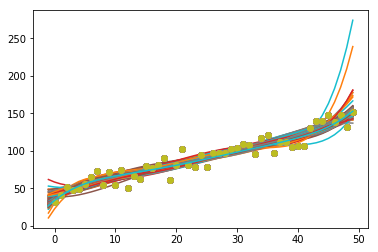

In [50]:
bagging(X, Y, 100, deg=5)

---
## Question 5
Look at the code in ``rnd.py`` for the algorithm used. Basically I used Linear congruential generator.

some random number: 2147483476


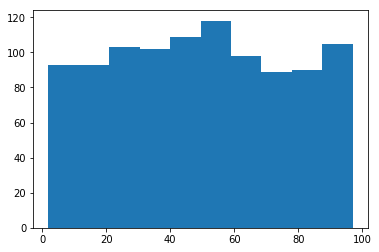

In [59]:
N = 100

from rnd import Uniform
gen = Uniform(seed=6)
print ("some random number:", gen.sample())
y = [gen.random_between(start=1,
                        end=N) \
     for i in range(1000)]
plt.hist(y);